In [1]:
#----------------------------------------------------------------
# Load libraries
#----------------------------------------------------------------
import numpy as np
import math
from gwpy.timeseries import TimeSeries

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

import os

%matplotlib inline



In [2]:
#----------------------------------------------------------------
# Set parameters
#----------------------------------------------------------------
fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' # data file
tevent = 1126259462.422 # Mon Sep 14 09:50:45 GMT 2015
evtname = 'GW150914' # event name

detector = 'H1' # detecotr: L1 or H1


In [3]:
#----------------------------------------------------------------
# Load LIGO data
#----------------------------------------------------------------
strain = TimeSeries.read(fn, format='hdf5.losc')
center = int(tevent)
strain = strain.crop(center-16, center+16)


<IPython.core.display.Javascript object>


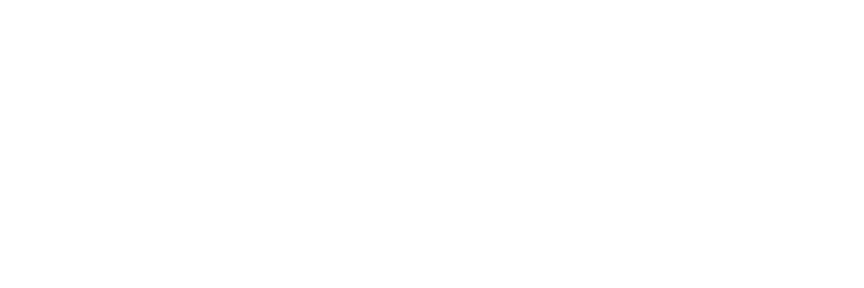

In [4]:
#----------------------------------------------------------------
# Show LIGO strain vs. time
#----------------------------------------------------------------
%matplotlib notebook 

strain.plot()
plt.ylabel('strain')
plt.show()


<IPython.core.display.Javascript object>


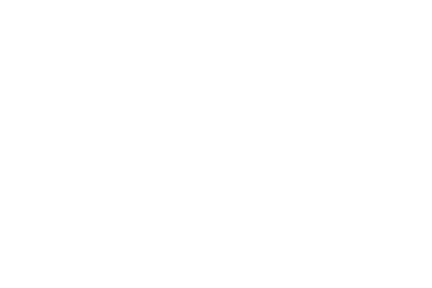

In [5]:
#----------------------------------------------------------------
# Obtain the power spectrum density PSD / ASD
#----------------------------------------------------------------

asd = strain.asd(fftlength=8)

%matplotlib notebook 

asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()



<IPython.core.display.Javascript object>


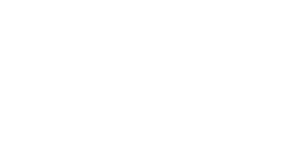

In [6]:
#----------------------------------------------------------------
# Whitening data
#----------------------------------------------------------------
%matplotlib notebook

white_data = strain.whiten()

white_data.plot()
plt.ylabel('strain (whitened)')
plt.show()



<IPython.core.display.Javascript object>


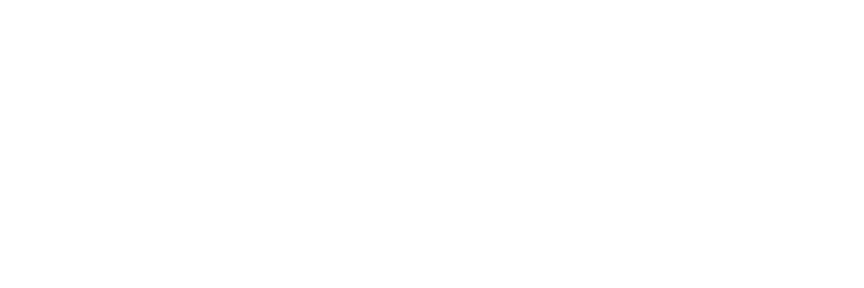

In [7]:
#----------------------------------------------------------------
# Bandpass filtering
#----------------------------------------------------------------

### thresholds below need to be set manually
bandpass_low = 80
bandpass_high = 180

### 100, 300 works ok

%matplotlib notebook

white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.show()



<IPython.core.display.Javascript object>


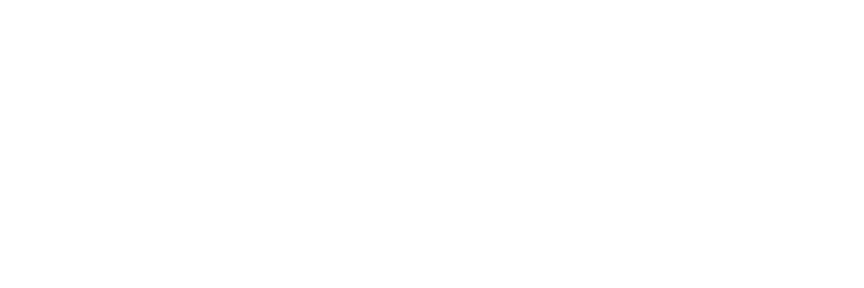

In [8]:
### zoom in on signal

white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.xlim(tevent-0.17, tevent+0.13)
plt.show()

<IPython.core.display.Javascript object>


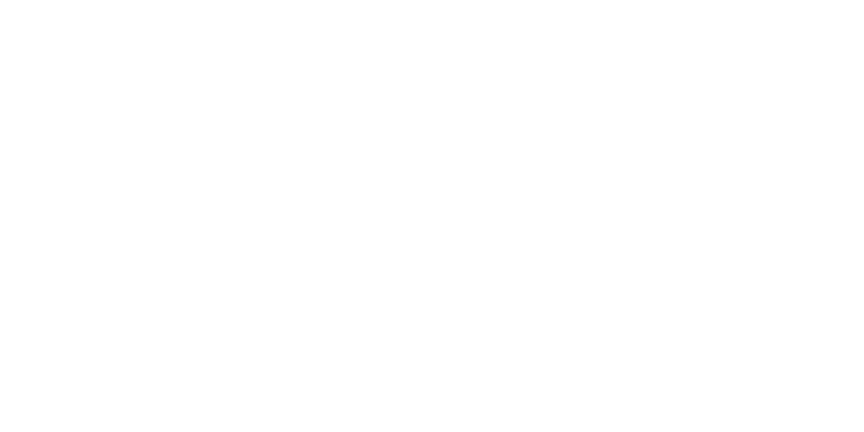

/home/elenarom/miniconda3/envs/gw/lib/python3.7/site-packages/gwpy/plot/plot.py:395: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = super().colorbar(mappable, **kwargs)


In [9]:
#----------------------------------------------------------------
# q-transform
#----------------------------------------------------------------

dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))


%matplotlib notebook
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.5, tevent+0.4)
plt.ylim(0, 400)
plt.ylabel('Frequency (Hz)')
plt.show()

In [10]:
# ### uh what does this cell do??

# %%javascript
# MathJax.Hub.Config({
#     TeX: { equationNumbers: { autoNumber: "AMS" } }
# });


<IPython.core.display.Javascript object>


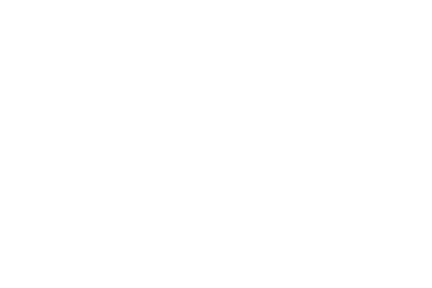

In [11]:
#----------------------------------------------------------------
# Frequency analytic
#----------------------------------------------------------------
%matplotlib notebook

def gwfreq(iM,iT,iT0):
    const = (948.5)*np.power((1./iM),5./8.)
    output = const*np.power(np.maximum((iT0-iT),3e-2),-3./8.) # we can max it out above 500 Hz-ish
    return output

times = np.linspace(0., 4., 50)
freq = gwfreq(20, times, 4)

plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [12]:
### need to make up a function to fit here!!

def osc(t, Mc, t0, C, phi):
    result = []
    for i in t:
        w = gwfreq(Mc, i, t0)
        if i <= t0:
            f = C*(Mc*w)**(10/3)*math.cos(w*(i-t0)+phi)
        if i > t0:
            f = C*math.e**(-70*(i-t0))*(Mc*w)**(10/3)*math.cos(w*(i-t0)+phi)
        result.append(f)
    return result


<IPython.core.display.Javascript object>


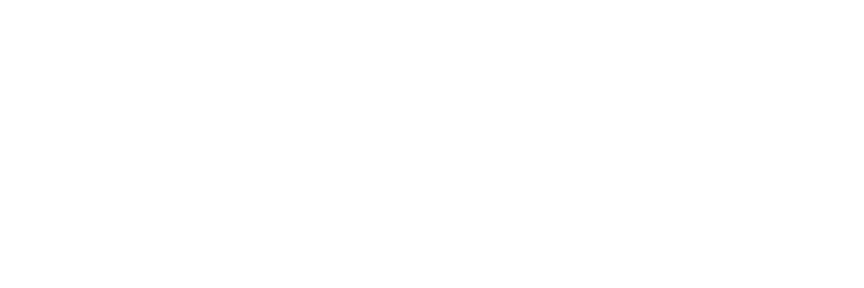

In [13]:
# Draw the function defined
times = np.linspace(-0.1, 0.3, 1000)

strain = osc(times, 30, 0.18, 1, 0.0)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, strain)
plt.xlabel('Time (s) since '+str(tevent))
plt.ylabel('strain')
plt.show()


In [14]:
# define osc_dif for lmfit::minimize()
def osc_dif(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    val=osc(x, iM, iT0, norm, phi)
    return (val-data)/eps

<IPython.core.display.Javascript object>


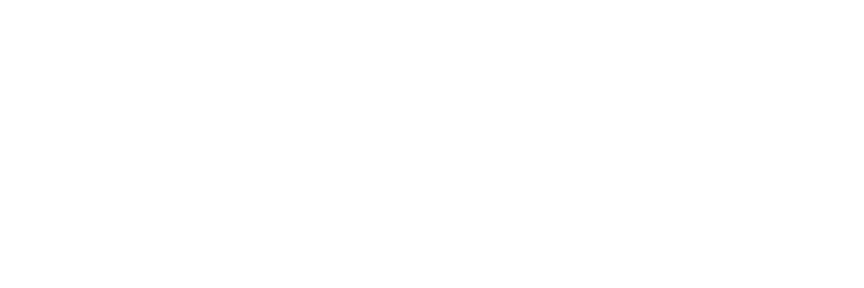

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 296
    # data points      = 1228
    # variables        = 4
    chi-square         = 0.30812910
    reduced chi-square = 2.5174e-04
    Akaike info crit   = -10172.5848
    Bayesian info crit = -10152.1323
[[Variables]]
    Mc:   15.9710192 +/- 0.18173181 (1.14%) (init = 20)
    t0:   0.17041021 +/- 5.9659e-04 (0.35%) (init = 0.18)
    C:   -2.7897e-14 +/- 1.4273e-15 (5.12%) (init = 2e-14)
    phi: -3.56181953 +/- 0.39891274 (11.20%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) =  0.983
    C(Mc, phi) = -0.889
    C(Mc, t0)  = -0.826
    C(Mc, C)   =  0.229
    C(C, phi)  = -0.188
    C(t0, C)   = -0.170


In [15]:
#----------------------------------------------------------------
# Fit
#----------------------------------------------------------------

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(20)     # Mass guess
p['t0'].set(0.18)  # By construction we put the merger in the center
p['C'].set(2e-14)      # normalization guess
p['phi'].set(0)    # Phase guess
unc = np.full(len(white_data_bp_zoom),20)
out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
plt.show()

In [16]:
# What you need to do: load the template database, fit the data, 
# and get more accurate parameters.

In [17]:
# What you need to do: develop a machinery to search for GW events across a long time range.

<IPython.core.display.Javascript object>


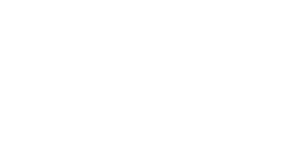

In [18]:
### residual analysis

residuals = []
for i in range(len(white_data_bp_zoom)):
    residuals.append(white_data_bp_zoom[i] - model.eval(params=out.params,t=x)[i])
    
%matplotlib notebook

plt.plot(x, residuals)
plt.show()

<IPython.core.display.Javascript object>


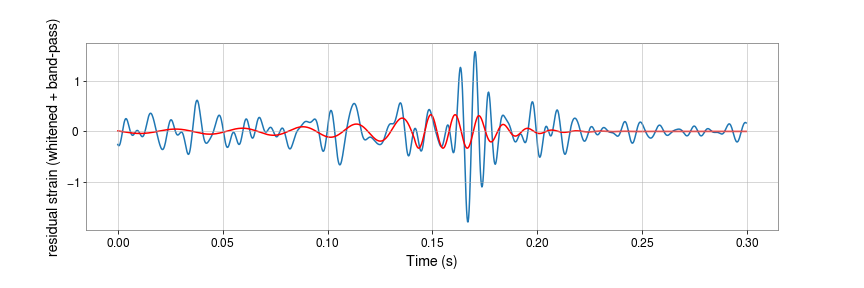

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 1228
    # variables        = 4
    chi-square         = 0.27664391
    reduced chi-square = 2.2602e-04
    Akaike info crit   = -10304.9481
    Bayesian info crit = -10284.4956
[[Variables]]
    Mc:   20.0122359 +/- 0.43268496 (2.16%) (init = 20)
    t0:   0.17135787 +/- 0.00111508 (0.65%) (init = 0.18)
    C:   -1.1743e-14 +/- 1.0458e-15 (8.91%) (init = 2e-14)
    phi: -3.69608976 +/- 0.64704320 (17.51%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) =  0.981
    C(Mc, phi) = -0.883
    C(Mc, t0)  = -0.815
    C(Mc, C)   =  0.308
    C(C, phi)  = -0.275
    C(t0, C)   = -0.255


In [19]:
### fitting residuals
%matplotlib notebook


residuals = np.asarray(residuals)

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, residuals)
plt.xlabel('Time (s)')
plt.ylabel('residual strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(20)     # Mass guess
p['t0'].set(0.18)  # By construction we put the merger in the center
p['C'].set(2e-14)      # normalization guess
p['phi'].set(0)    # Phase guess
unc = np.full(len(residuals),20)
out = minimize(osc_dif, params=p, args=(x, residuals, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
plt.show()